In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.8 MB/s 
     |████████████████████████████████| 88 kB 6.7 MB/s 
     |████████████████████████████████| 96 kB 4.2 MB/s 
     |████████████████████████████████| 11.2 MB 32.0 MB/s 
     |████████████████████████████████| 965 kB 46.8 MB/s 
     |████████████████████████████████| 1.1 MB 43.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=33d26650d0d256176d481e49a5c84774364b5059c10b46433780a266180aa888
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=606a9e4be40962545aa96b145abbd650e2d1944ca0cc1df9a346aba5b13fc064
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8

In [ ]:
import scanpy as sc

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.12.2 pynndescent==0.5.8


In [ ]:
results_file = 'write/pmbcs10k.h5ad'  # the file that will store the analysis results

In [ ]:
cd MyDrive

/content/drive/MyDrive


In [ ]:
adata = sc.read_10x_mtx(
    'filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

... reading from cache file cache/filtered_feature_bc_matrix-matrix.h5ad


In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [ ]:
adata

AnnData object with n_obs × n_vars = 11984 × 36601
    var: 'gene_ids', 'feature_types'

### Preprocessing

normalizing counts per cell
    finished (0:00:00)


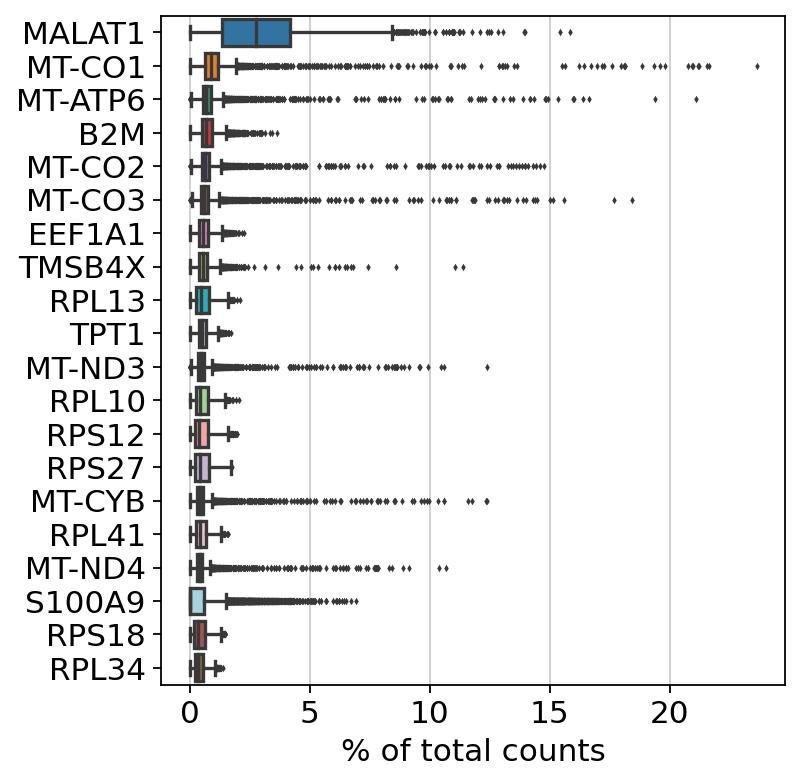

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 32 cells that have less than 200 genes expressed
filtered out 9238 genes that are detected in less than 3 cells


In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

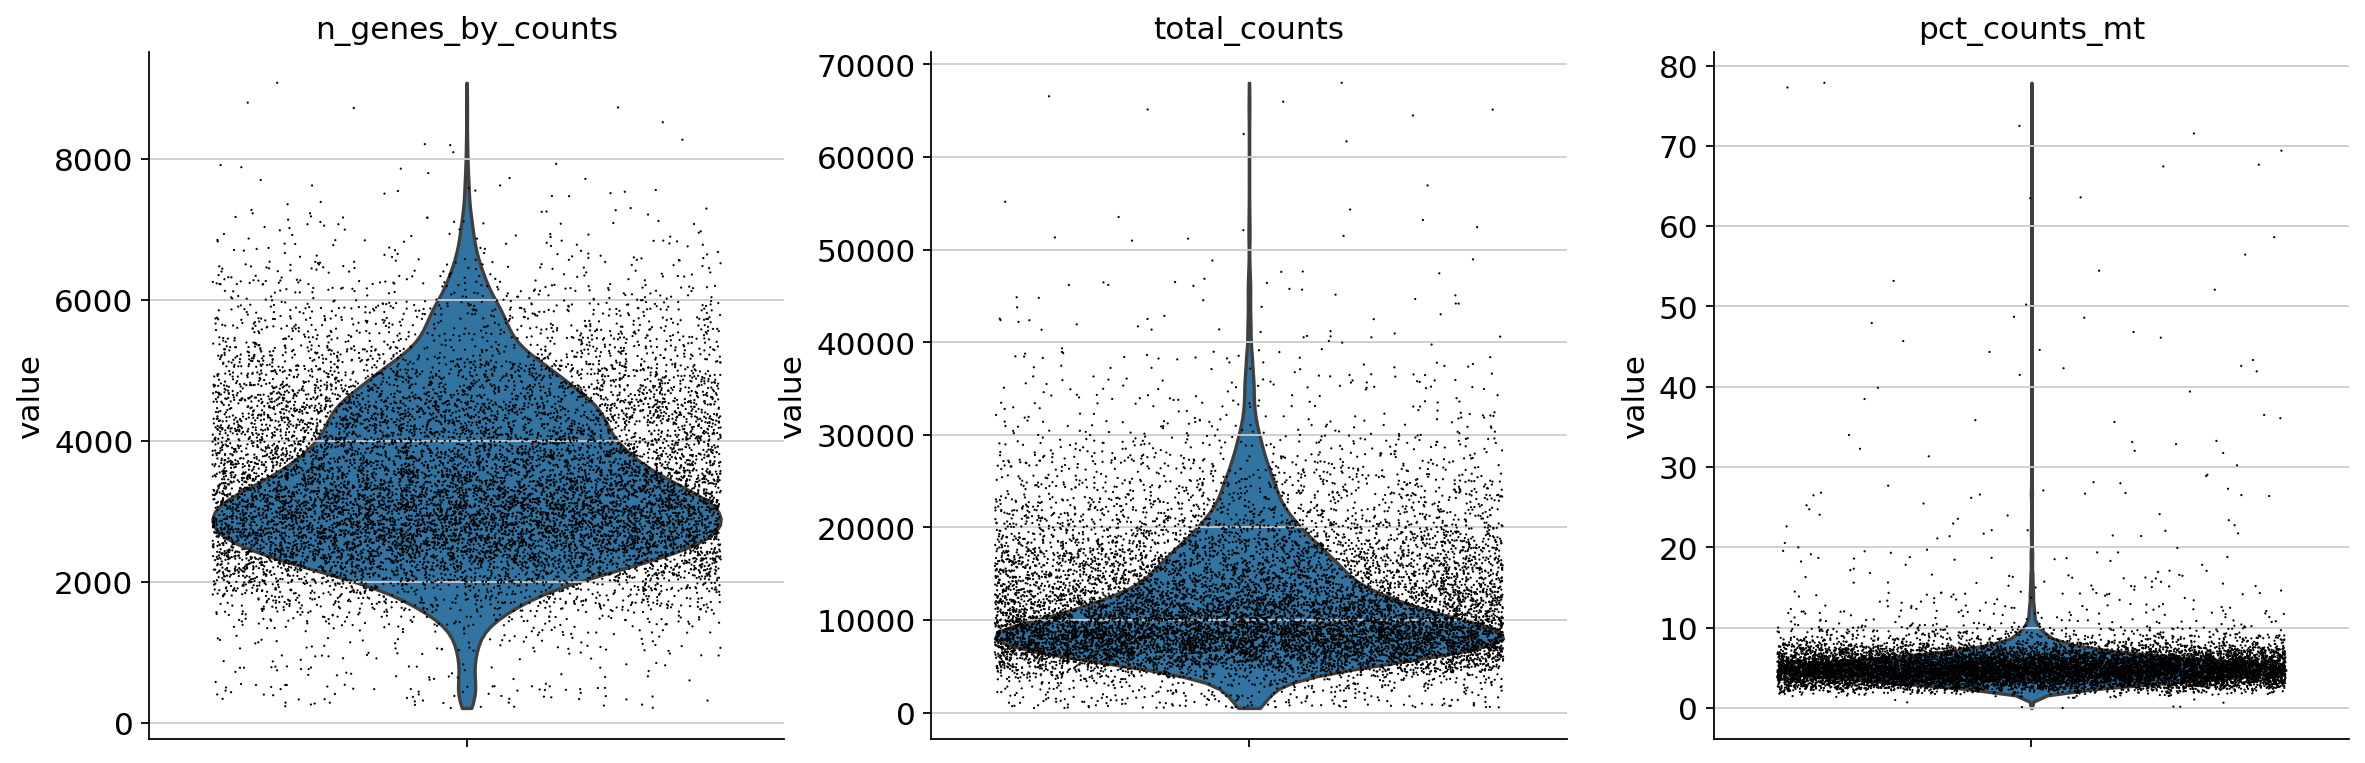

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

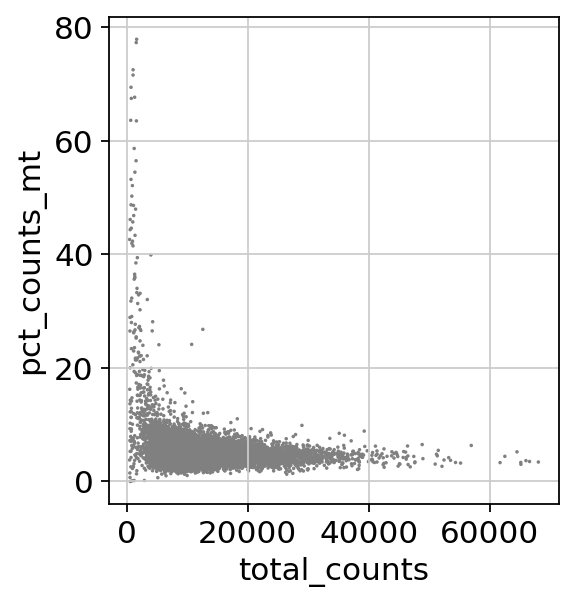

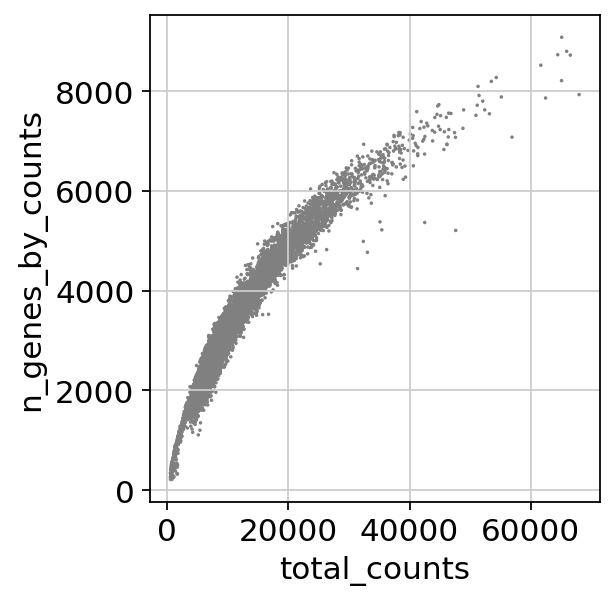

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


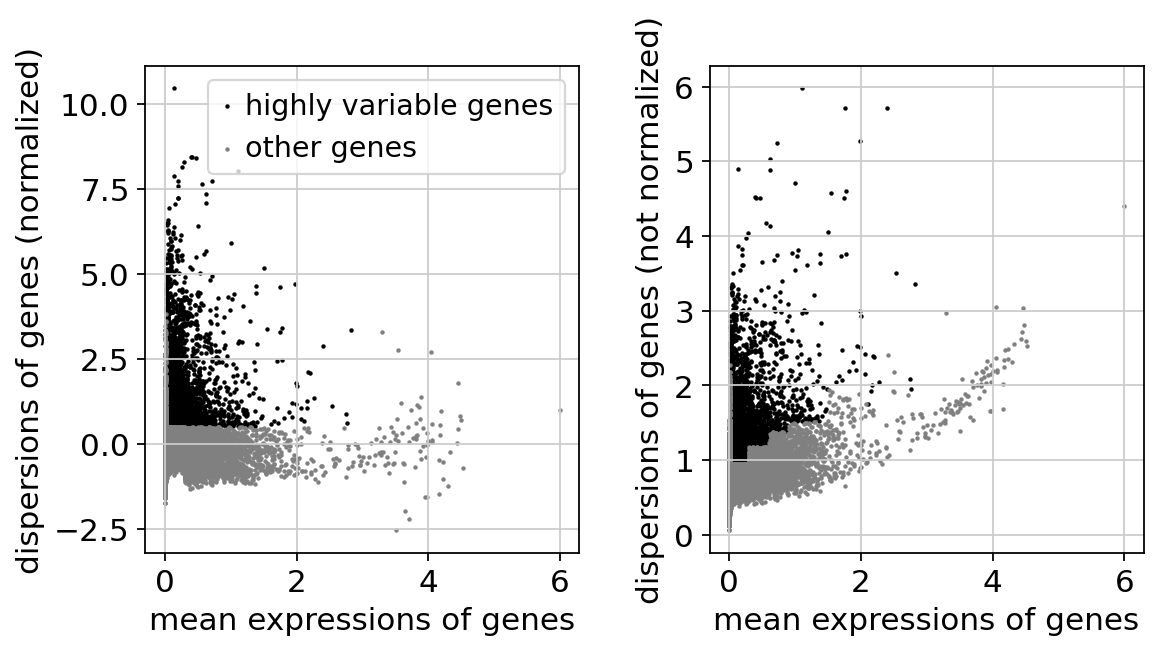

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.raw = adata

In [ ]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:23)


In [ ]:
sc.pp.scale(adata, max_value=10)

###Principal component analysis

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


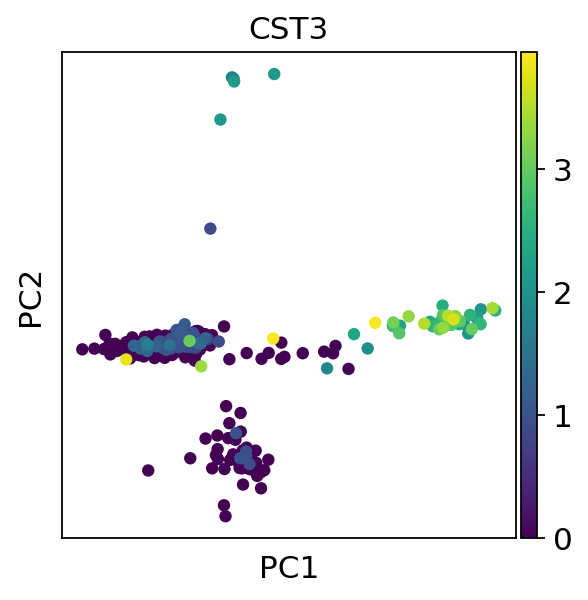

In [ ]:
sc.pl.pca(adata, color='CST3')

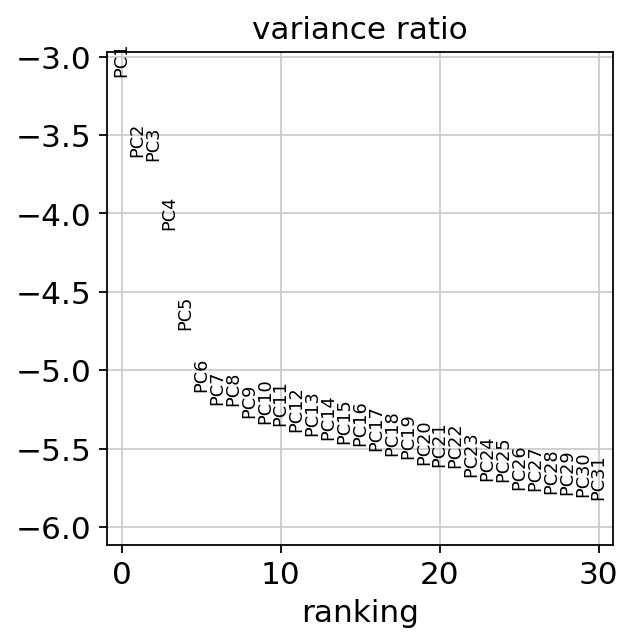

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata.write(results_file)

OSError: ignored

In [ ]:
adata

AnnData object with n_obs × n_vars = 964 × 3553
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs'

###Computing the neighborhood graph

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


###Embedding the neighborhood graph

In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


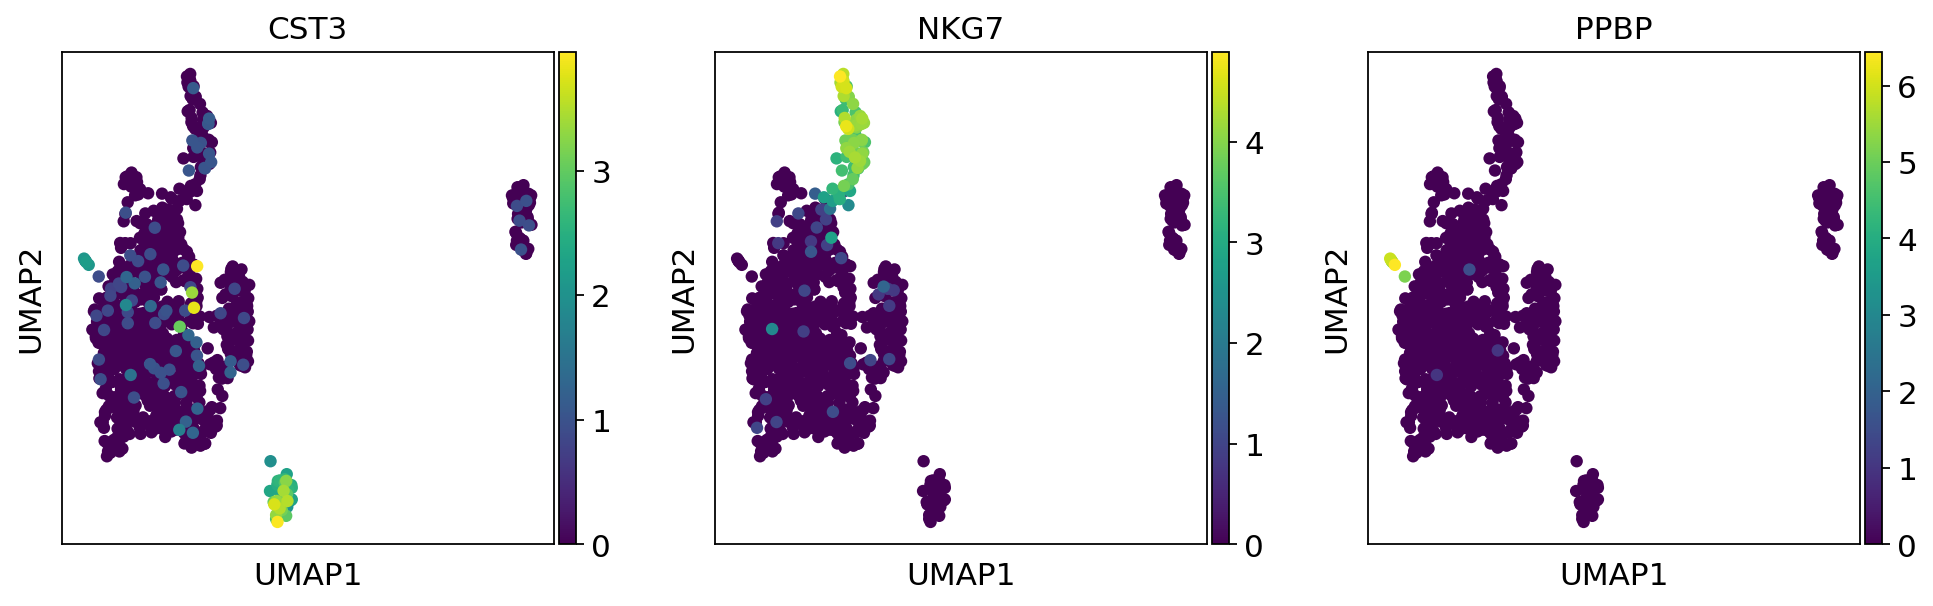

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

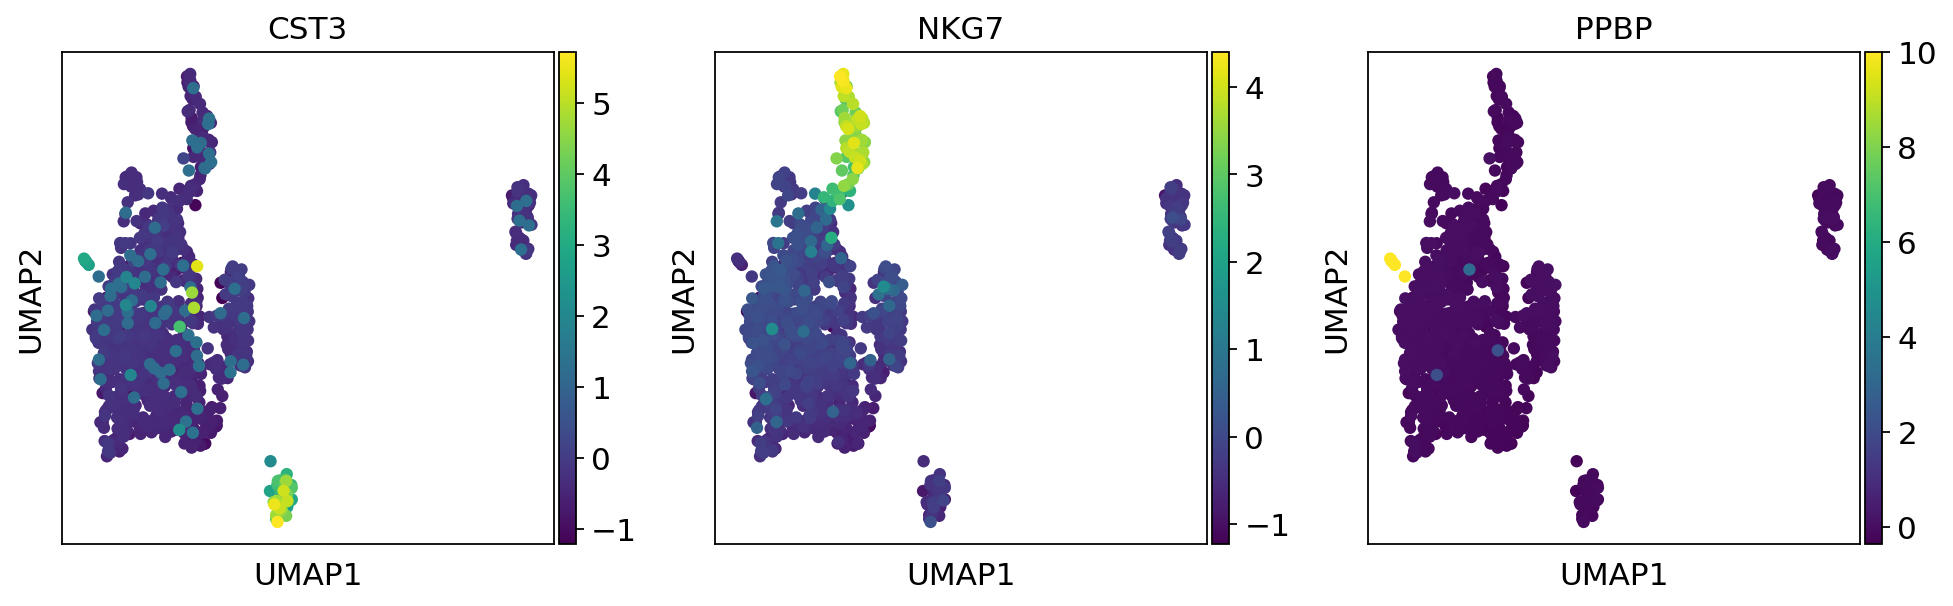

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

###Clustering the neighborhood graph

In [ ]:
pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
     |████████████████████████████████| 3.2 MB 33.6 MB/s 


In [ ]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


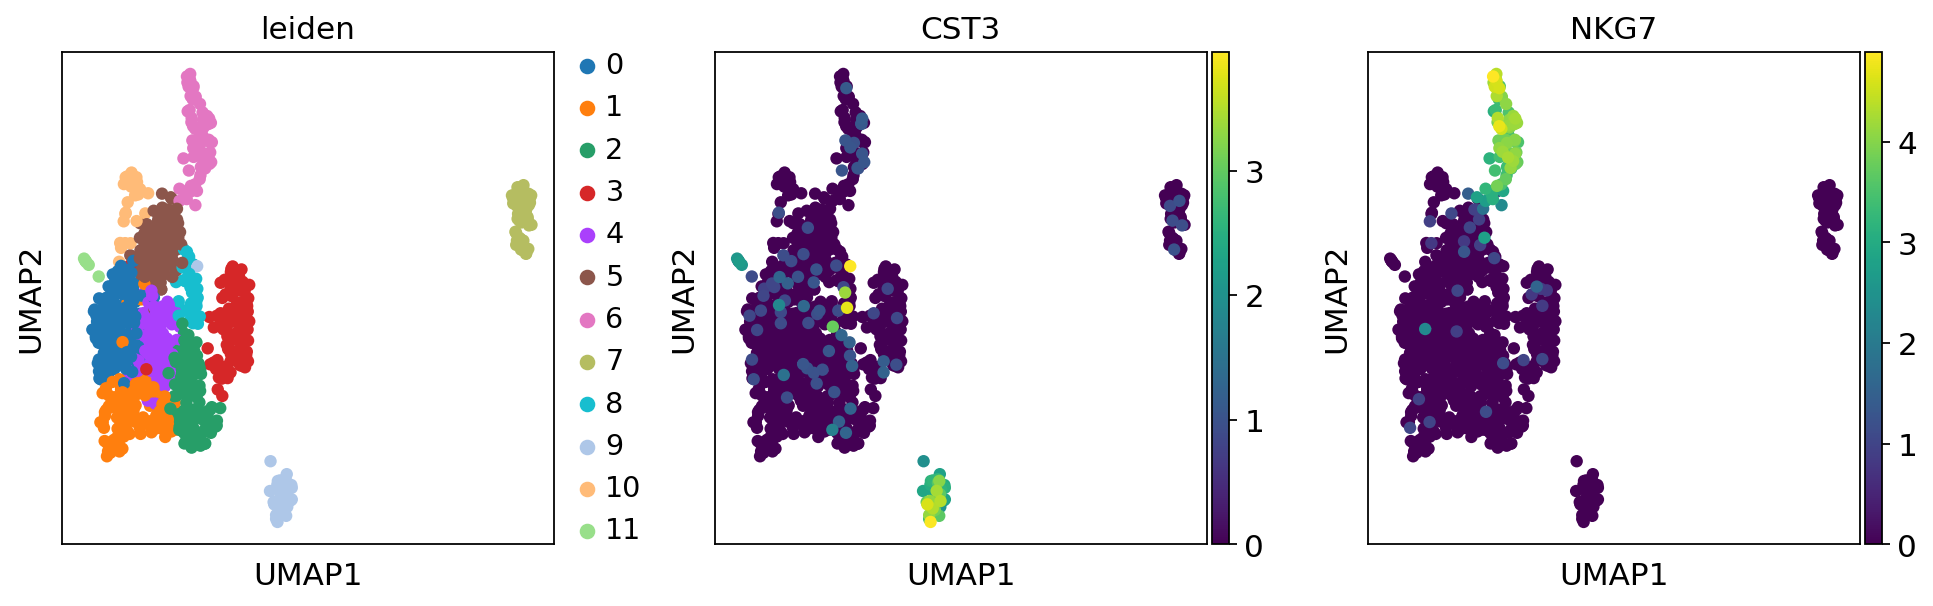

In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

###Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


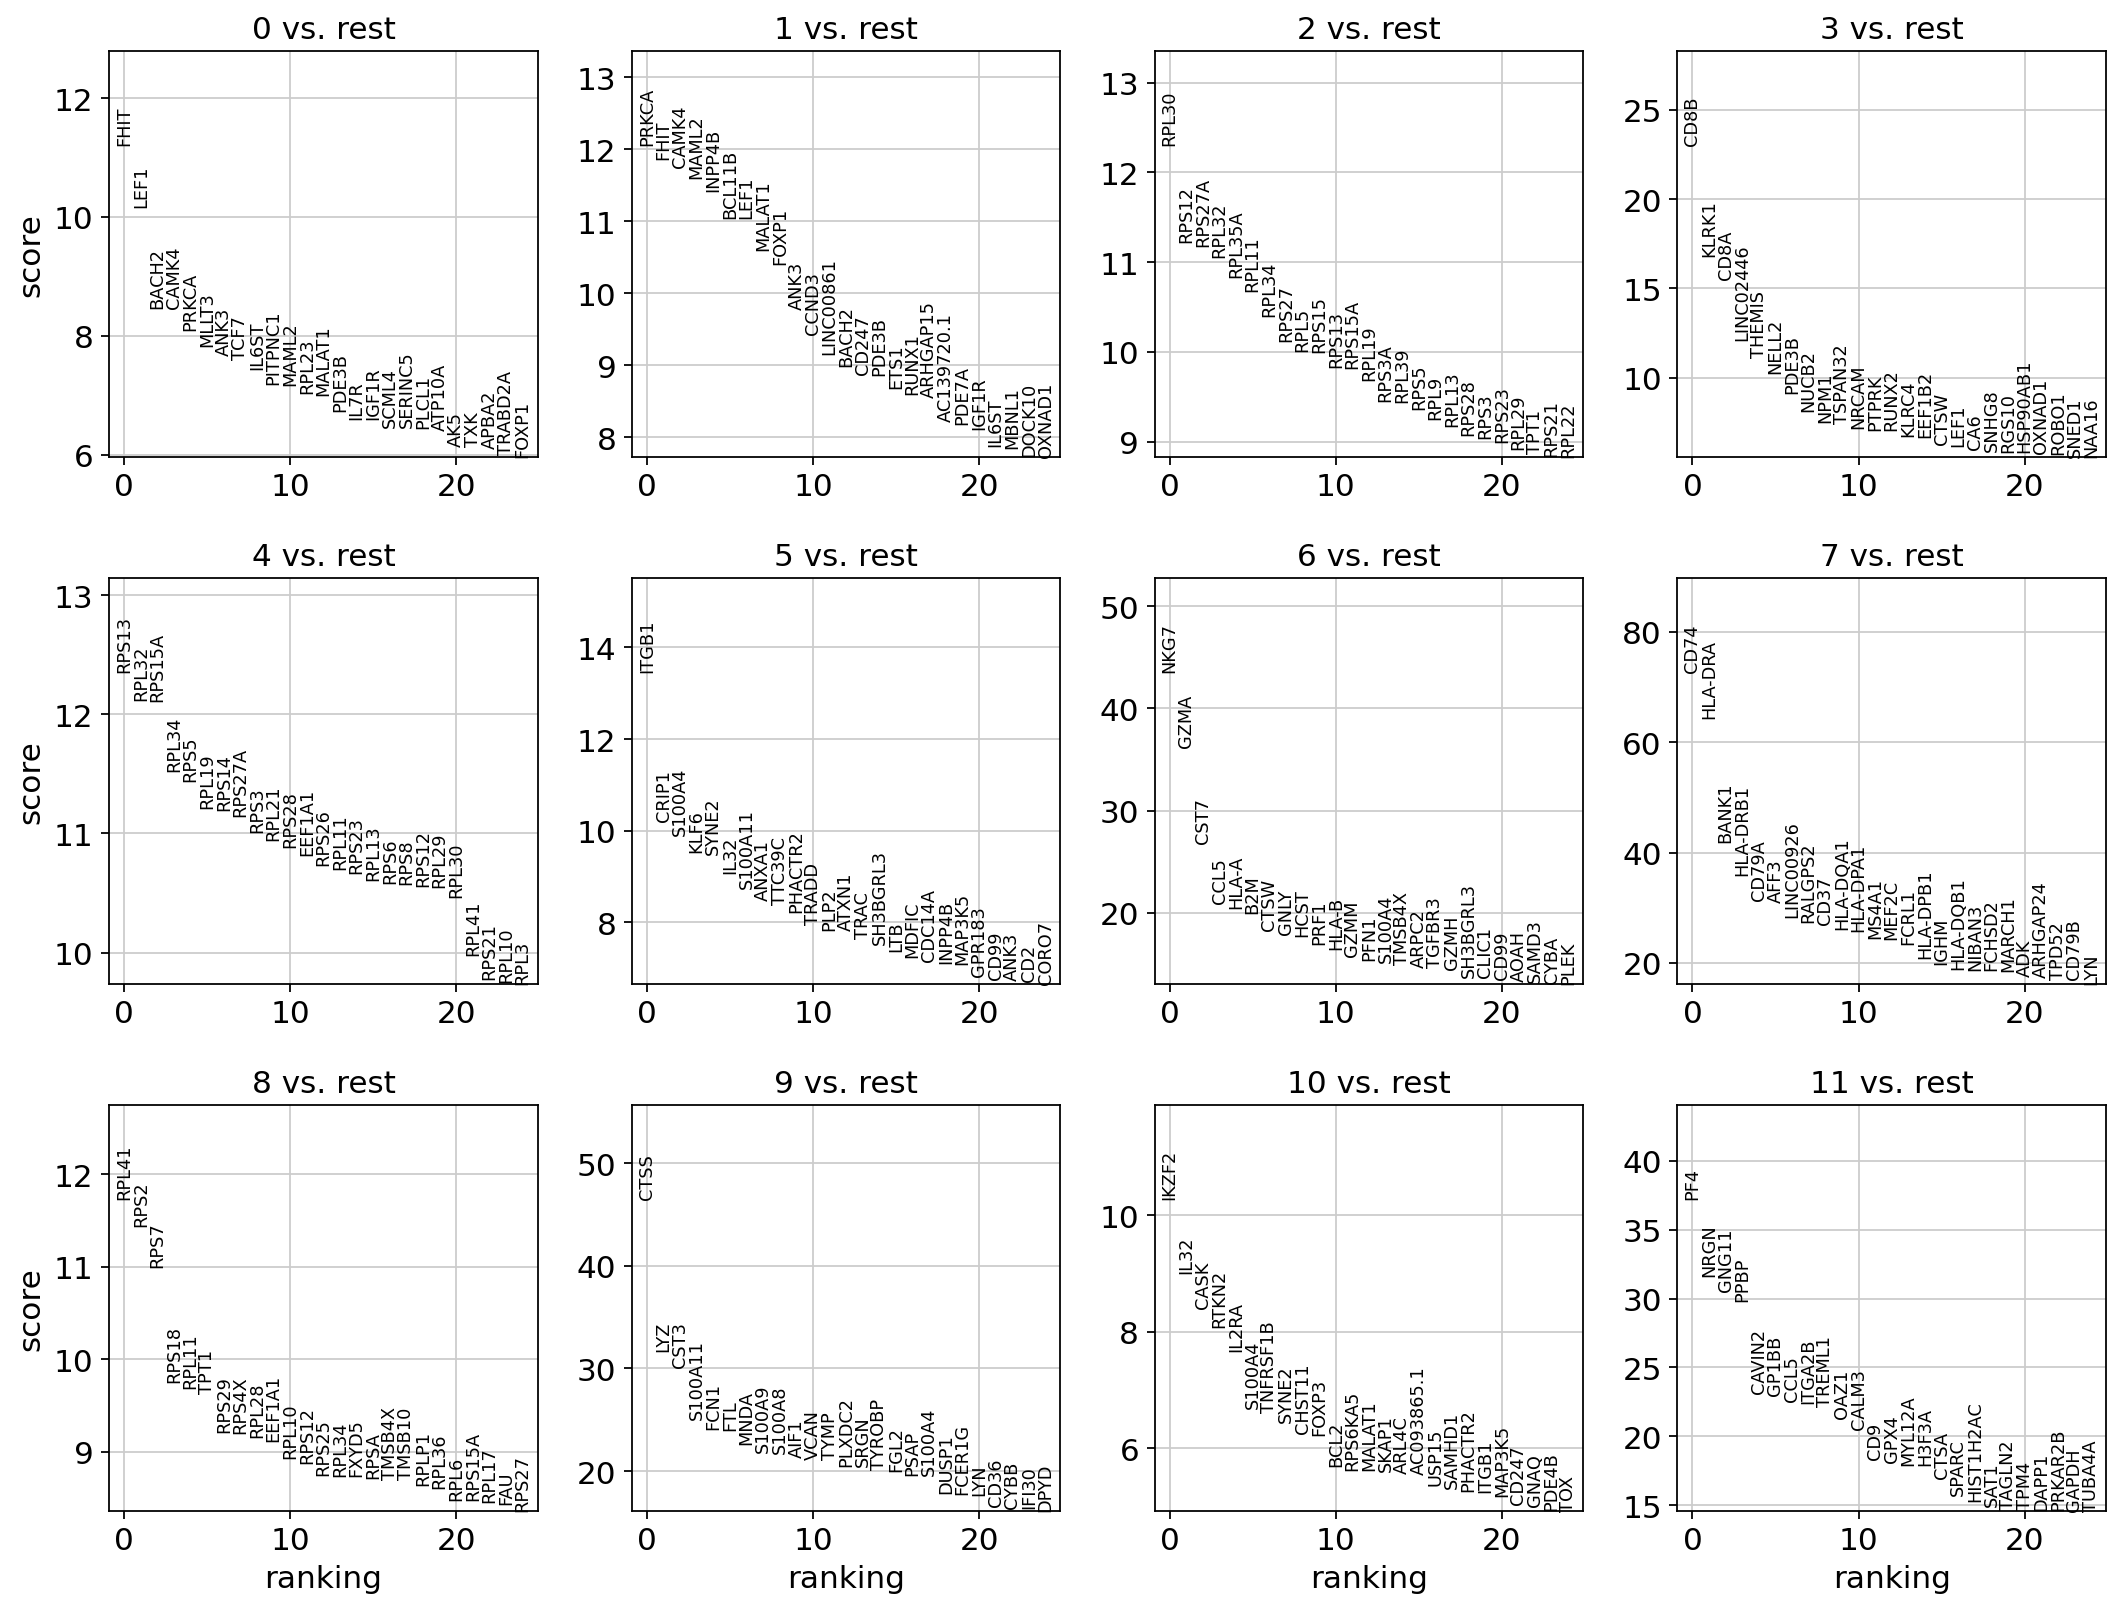

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:04)


/usr/local/lib/python3.7/dist-packages/scanpy/plotting/_tools/__init__.py:397: UserWarning: Attempting to set identical bottom == top == 4.227224826812744 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)


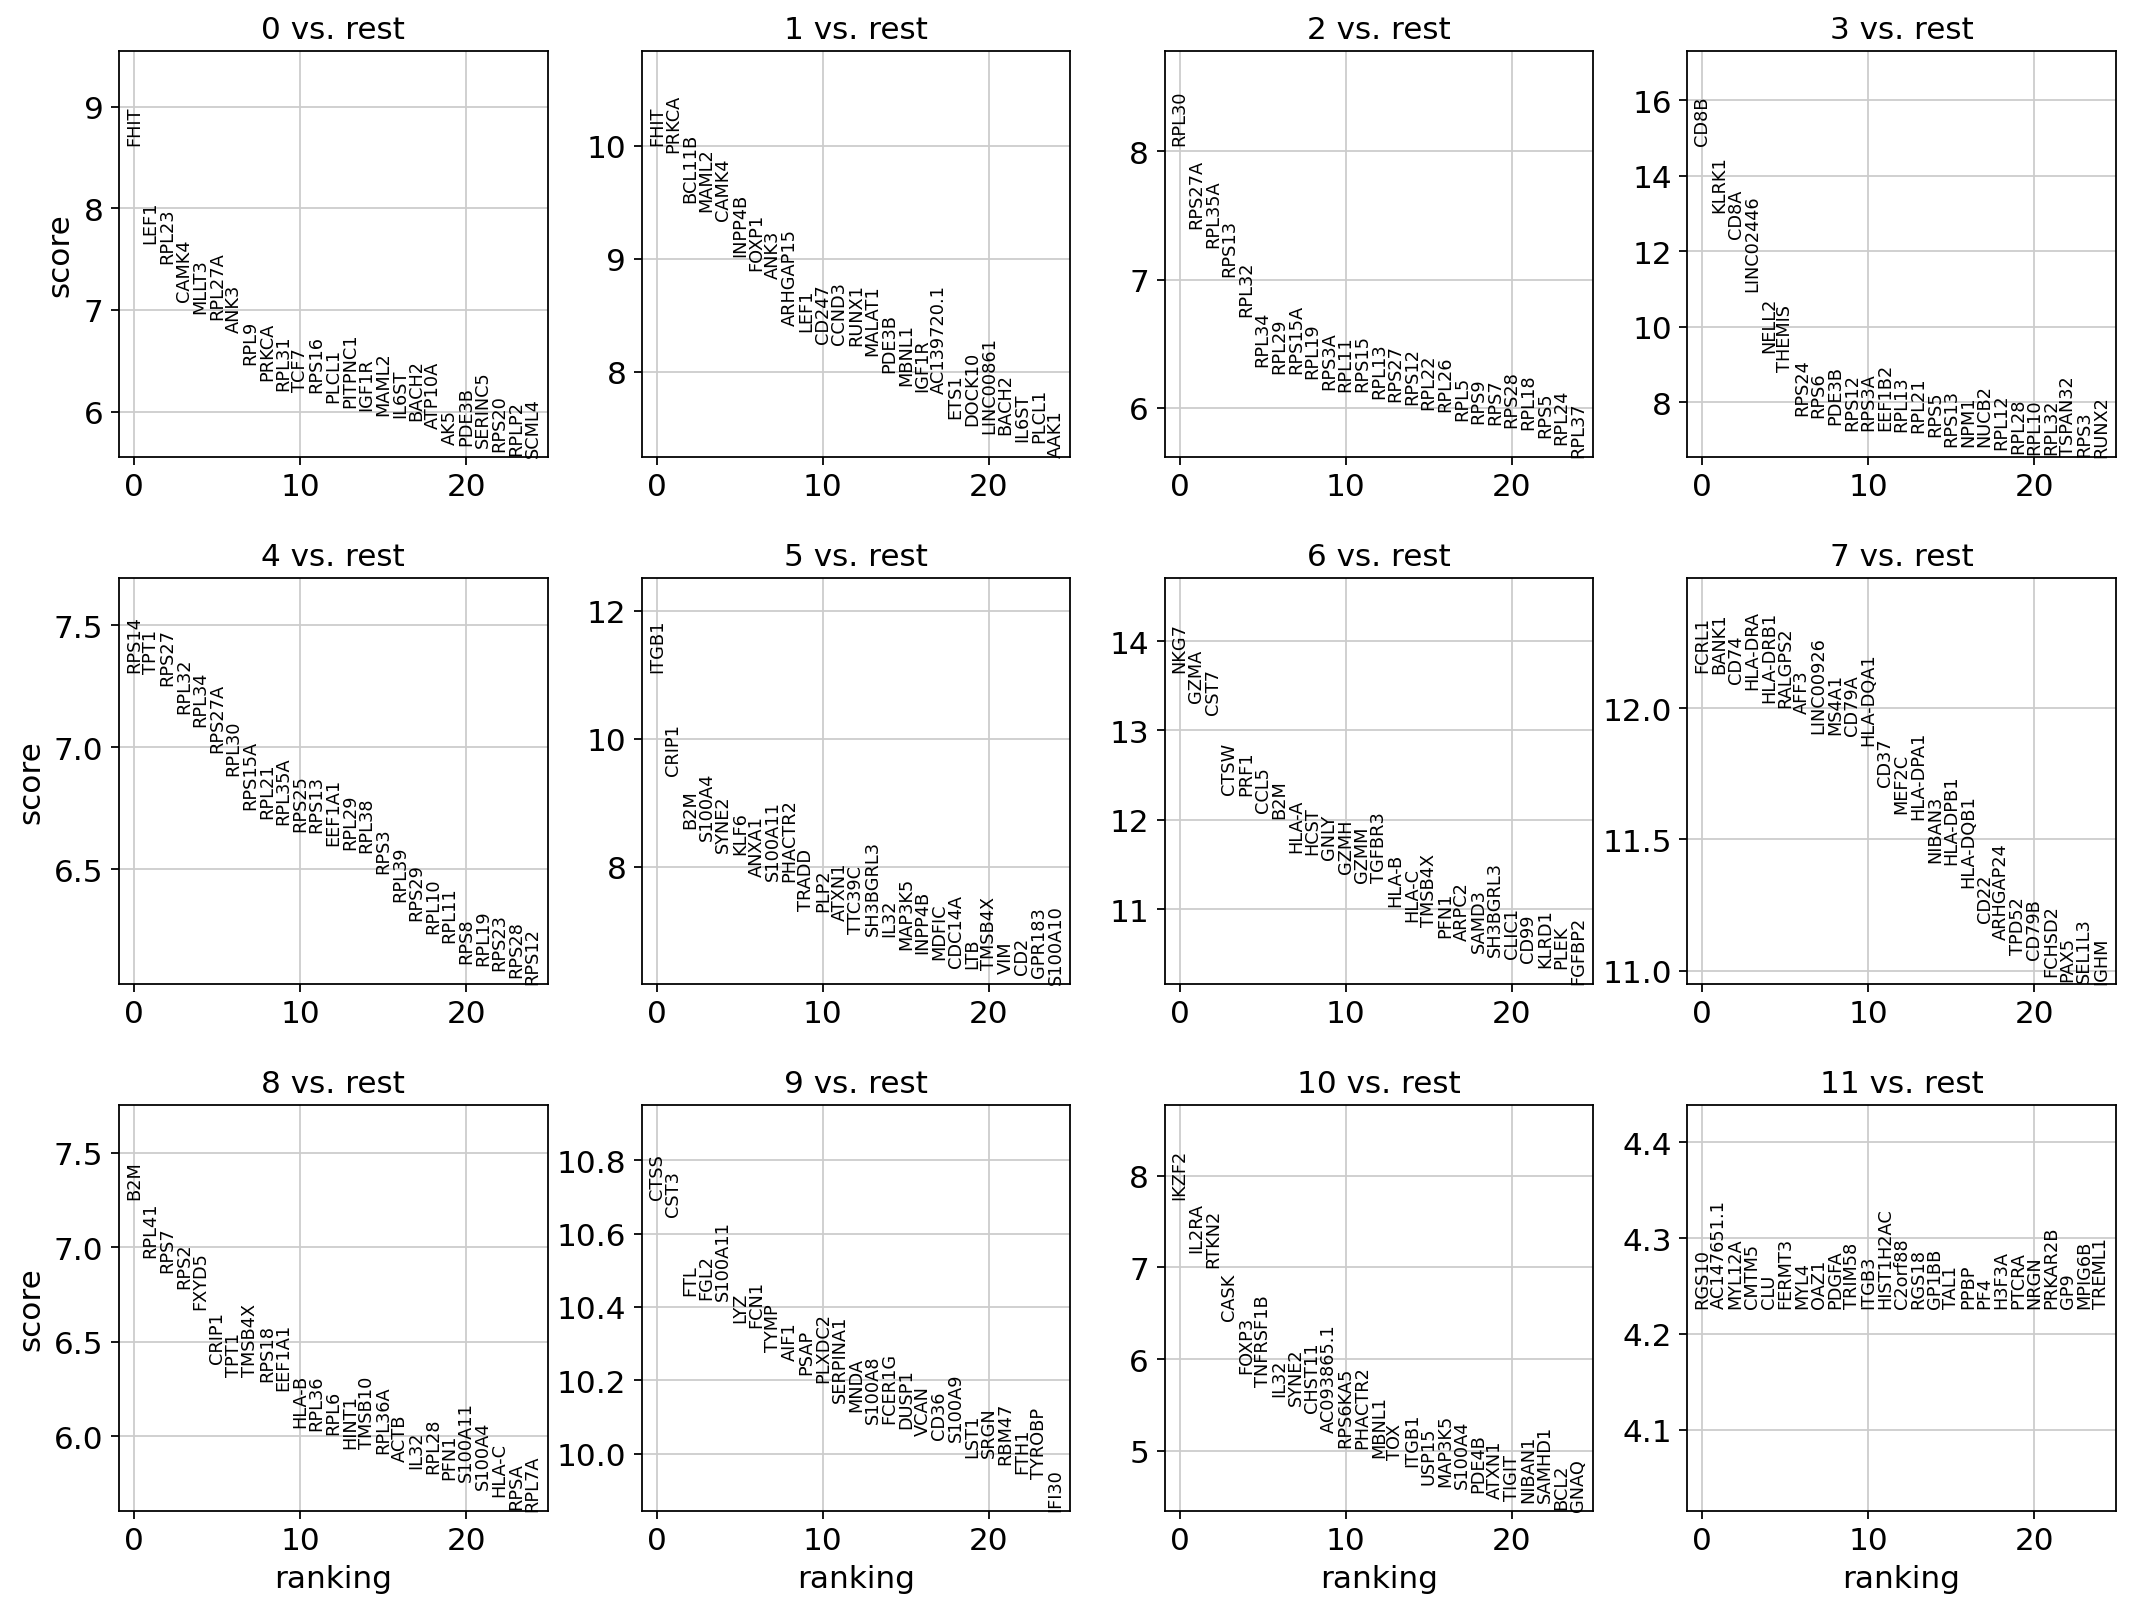

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)